<a href="https://colab.research.google.com/github/eternalsky0/IT-Arkhangelsk/blob/main/ICE_CUBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- БЛОК 1: УСТАНОВКА ---
import sys

# Устанавливаем библиотеки (тихо, без лишнего шума)
!pip install rasterio opencv-python-headless matplotlib ipywidgets > /dev/null

import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import io
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

print("✅ Библиотеки установлены и готовы к работе!")

✅ Библиотеки установлены и готовы к работе!


In [ ]:
# --- БЛОК 2: АЛГОРИТМ ОБРАБОТКИ ---

def process_sar_image(input_filename):
    """
    Читает TIF, применяет метод Оцу, возвращает маску и путь к сохраненному файлу.
    """
    output_filename = "processed_mask.tif"

    try:
        # 1. Чтение
        with rasterio.open(input_filename) as src:
            sar_data = src.read(1) # Читаем 1-й канал
            profile = src.profile  # Сохраняем гео-привязку (координаты)

            # Если данных нет или они пустые
            if sar_data is None or sar_data.size == 0:
                return None, "Ошибка чтения файла"

        # 2. Препроцессинг (Улучшение контраста)
        # Обрезаем экстремальные значения (шум)
        p2, p98 = np.percentile(sar_data, (2, 98))
        img_clipped = np.clip(sar_data, p2, p98)

        # Нормализация в 0-255 для OpenCV
        img_norm = cv2.normalize(img_clipped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # 3. Удаление шума (Speckle filter)
        img_blurred = cv2.medianBlur(img_norm, 5)

        # 4. Бинаризация Оцу
        thresh_val, mask = cv2.threshold(img_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 5. Морфология (чистка маски)
        kernel = np.ones((5,5), np.uint8)
        mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # убрать белый шум
        mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel) # закрыть дырки во льду

        # 6. Сохранение результата (с гео-привязкой!)
        profile.update(dtype=rasterio.uint8, count=1, nodata=0)
        with rasterio.open(output_filename, 'w', **profile) as dst:
            dst.write(mask_clean, 1)

        return (img_norm, mask_clean, output_filename), "Успех"

    except Exception as e:
        return None, f"Ошибка обработки: {str(e)}"

print("✅ Алгоритм загружен в память!")

✅ Алгоритм загружен в память!


In [ ]:
!pip install imagecodecs

⚖️ Генерация СБАЛАНСИРОВАННОЙ версии (Engine: Rasterio): DMS_1842639_00120_20180407_18061659.tif
✅ Файл прочитан. Размер: (5241, 6981)
📉 Ресайз: 6981x5241 -> 3490x2620
🧠 Кластеризация...
📐 Векторизация (Сохраняем изгибы)...
✅ Файл сохранен: arctic_route_balanced.geojson
Количество полигонов: 8289
📊 Рисуем отчет...


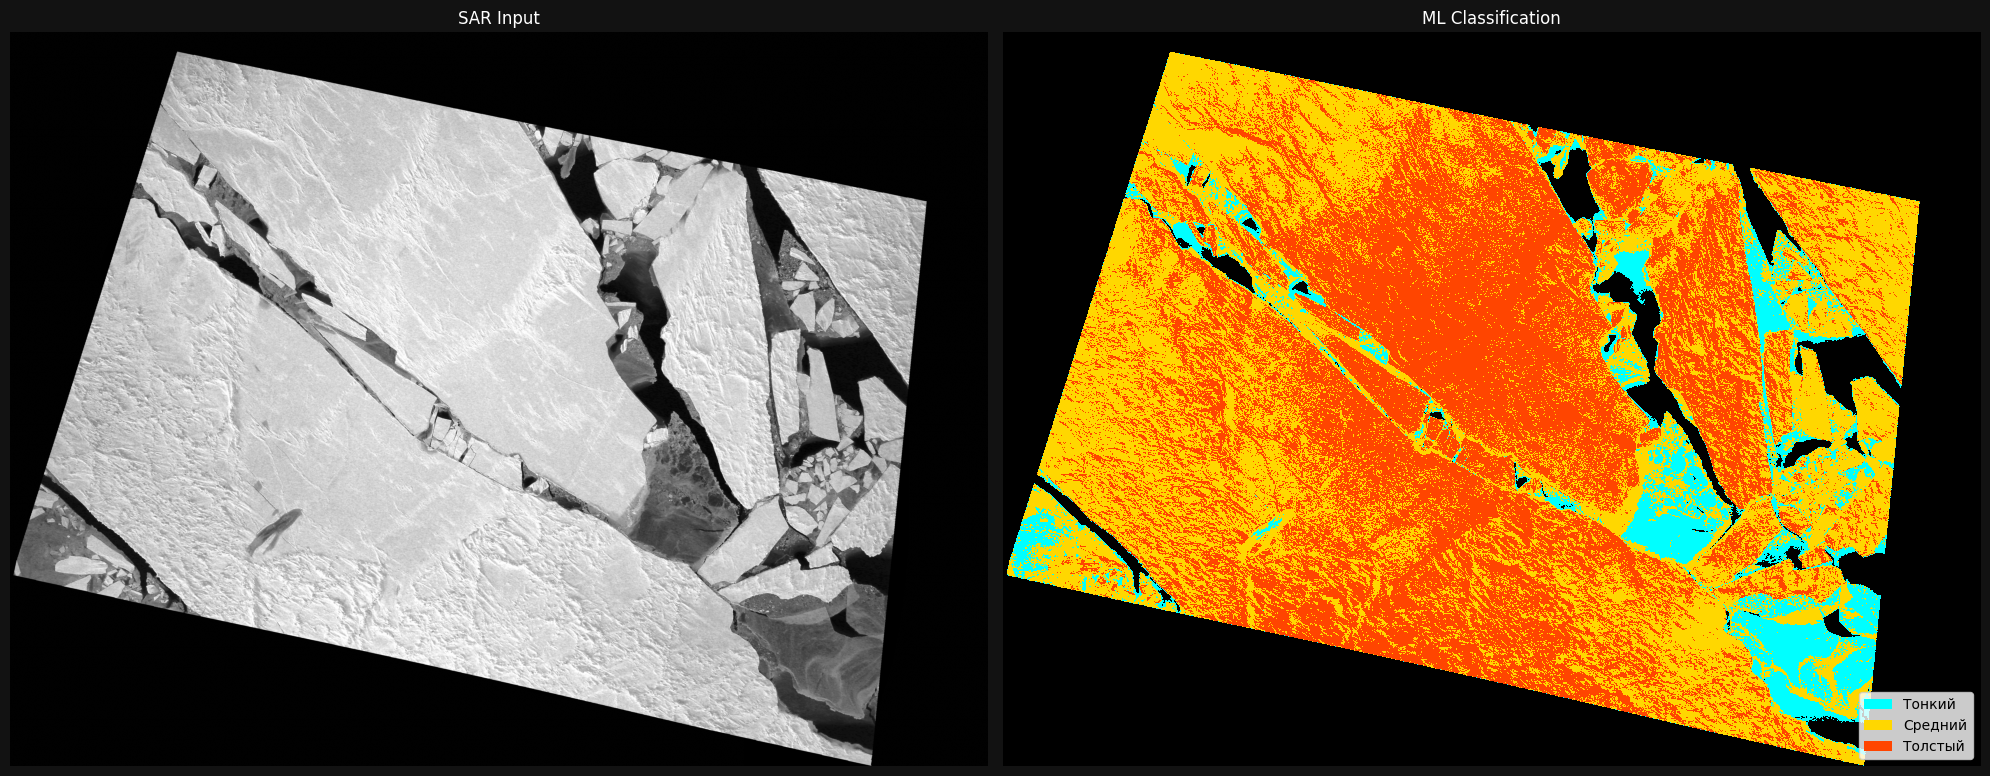

In [ ]:
import rasterio
from rasterio.features import shapes
from rasterio.transform import Affine
import cv2
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# --- НАСТРОЙКИ ЦВЕТОВ ---
COLORS = {
    "thin":   "#00FFFF", # Cyan
    "medium": "#FFD700", # Gold
    "thick":  "#FF4500"  # OrangeRed
}

def create_balanced_product_final(tif_path, output_json="arctic_route_balanced.geojson"):
    print(f"⚖️ Генерация СБАЛАНСИРОВАННОЙ версии (Engine: Rasterio): {tif_path}")

    # 1. ЧТЕНИЕ (ИСПРАВЛЕНО: используем rasterio вместо tifffile)
    try:
        with rasterio.open(tif_path) as src:
            base_transform = src.transform
            crs = src.crs
            # Читаем 1-й канал
            img_raw = src.read(1)
            print(f"✅ Файл прочитан. Размер: {img_raw.shape}")
    except Exception as e:
        return print(f"❌ Ошибка чтения: {e}")

    # 2. МАСШТАБ 50% (Оптимально для веба и деталей)
    SCALE = 0.5
    h, w = img_raw.shape
    new_h, new_w = int(h * SCALE), int(w * SCALE)

    print(f"📉 Ресайз: {w}x{h} -> {new_w}x{new_h}")
    img_resized = cv2.resize(img_raw, (new_w, new_h), interpolation=cv2.INTER_AREA)
    new_transform = base_transform * Affine.scale(1/SCALE, 1/SCALE)

    # 3. ФИЧИ (Яркость + Текстура)
    img_float = img_resized.astype(np.float32)
    # Защита от NaN
    img_float = np.nan_to_num(img_float, nan=0.0)

    p1, p99 = np.percentile(img_float, (1, 99))
    img_clipped = np.clip(img_float, p1, p99)

    # Яркость
    img_int = cv2.normalize(img_clipped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_int = clahe.apply(img_int)

    # Текстура (быстрая)
    blur = cv2.blur(img_int.astype(np.float32), (3,3))
    img_tex = cv2.normalize(np.abs(img_int - blur), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 4. ML КЛАССИФИКАЦИЯ
    mask_valid = img_int > 0
    val_int = img_int[mask_valid].reshape(-1, 1).astype(np.float32)
    val_tex = img_tex[mask_valid].reshape(-1, 1).astype(np.float32)

    scaler = MinMaxScaler()
    # Вес яркости выше (1.5), чтобы большие поля были цельными
    # Вес текстуры (1.0) выделяет торосы
    f1 = scaler.fit_transform(val_int) * 1.5
    f2 = scaler.fit_transform(val_tex) * 1.0
    features = np.hstack((f1, f2))

    print("🧠 Кластеризация...")
    kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=4096, n_init=3)
    labels = kmeans.fit_predict(features)

    # Сортировка и Маппинг
    centers = kmeans.cluster_centers_
    scores = centers[:, 0] + centers[:, 1]
    sorted_idx = np.argsort(scores)

    remap = {
        sorted_idx[0]: 0, # Вода
        sorted_idx[1]: 1, # Тонкий
        sorted_idx[2]: 2, # Средний
        sorted_idx[3]: 2, # Средний
        sorted_idx[4]: 3  # Толстый
    }

    remapped = np.vectorize(remap.get)(labels)
    class_map = np.zeros_like(img_int)
    class_map[mask_valid] = remapped

    # 5. ВЕКТОРИЗАЦИЯ (АККУРАТНАЯ)
    print("📐 Векторизация (Сохраняем изгибы)...")
    gdf_list = []
    ice_info = {
        1: {"name": "Thin Ice",   "color": COLORS["thin"]},
        2: {"name": "Medium Ice", "color": COLORS["medium"]},
        3: {"name": "Thick Ice",  "color": COLORS["thick"]}
    }

    # Ядро 3x3 - убирает только "песок", не ломая формы
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    for cid, info in ice_info.items():
        mask_layer = (class_map == cid).astype('uint8')

        # Мягкая чистка
        mask_layer = cv2.morphologyEx(mask_layer, cv2.MORPH_OPEN, kernel)

        # Фильтр площади (30px = детали сохраняются)
        min_area = 30
        num, labs, stats, _ = cv2.connectedComponentsWithStats(mask_layer, 4)
        clean_mask = np.zeros_like(mask_layer)
        for i in range(1, num):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                clean_mask[labs == i] = 1

        if clean_mask.sum() == 0: continue

        results = (
            {'properties': {'ice_type': info['name'], 'fill': info['color']}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(clean_mask, mask=clean_mask.astype('bool'), transform=new_transform))
        )
        gdf_list.append(gpd.GeoDataFrame.from_features(list(results)))

    if gdf_list:
        full_gdf = pd.concat(gdf_list, ignore_index=True)
        if crs:
            full_gdf.set_crs(crs, inplace=True)
            full_gdf = full_gdf.to_crs(epsg=4326)

        # Упрощение: 0.0001 (~11 метров) - плавные линии
        full_gdf['geometry'] = full_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)

        # Округляем координаты до 5 знаков (1 метр) - экономим вес
        full_gdf.to_file(output_json, driver='GeoJSON', coordinate_precision=5)
        print(f"✅ Файл сохранен: {output_json}")
        print(f"Количество полигонов: {len(full_gdf)}")
    else:
        print("⚠️ Лед не найден.")

    # 6. ОТЧЕТ
    print("📊 Рисуем отчет...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.patch.set_facecolor('#121212')

    ax1.imshow(img_int, cmap='gray')
    ax1.set_title("SAR Input", color='white')
    ax1.axis('off')

    cmap_colors = ["black", COLORS["thin"], COLORS["medium"], COLORS["thick"]]
    custom_cmap = ListedColormap(cmap_colors)

    ax2.imshow(class_map, cmap=custom_cmap, interpolation='nearest')
    ax2.set_title("ML Classification", color='white')
    ax2.axis('off')

    legend_elements = [
        Patch(facecolor=COLORS["thin"],   label='Тонкий'),
        Patch(facecolor=COLORS["medium"], label='Средний'),
        Patch(facecolor=COLORS["thick"],  label='Толстый'),
    ]
    ax2.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()
    fig.savefig("balanced_report.png", facecolor=fig.get_facecolor())

# ЗАПУСК
FILENAME = "DMS_1842639_00120_20180407_18061659.tif"
create_balanced_product_final(FILENAME)

In [ ]:
!pip install scikit-image

🚢 ПОСТРОЕНИЕ ОПТИМАЛЬНОГО МАРШРУТА
📥 Загружаем GeoJSON: arctic_route_balanced.geojson
✅ Загружено 7680 полигонов
🗺️ Создаем растровую карту стоимости...
📐 Границы: [-146.01244   70.32619 -146.00047   70.33241]
📊 Размер растра: 519 x 1000
🧊 Наносим полигоны на растр...
  ✓ Thin Ice: 618 полигонов
  ✓ Medium Ice: 3938 полигонов
  ✓ Thick Ice: 3124 полигонов
📍 Ищем точки старта и финиша ВНУТРИ снимка...
✅ Найдено 409623 проходимых точек
🟢 Старт: (np.int64(0), np.int64(999)) (стоимость: 20.00)
🔴 Финиш: (np.int64(482), np.int64(0)) (стоимость: 20.00)
🧭 Строим маршрут алгоритмом Дейкстры...
✅ Маршрут построен!
   💰 Стоимость: 20579.91
   📏 Точек: 1090
🌍 Конвертируем в географические координаты...
📝 Создаем GeoJSON только с маршрутом...
✅ Маршрут сохранен: optimal_route.geojson
📊 Визуализация...


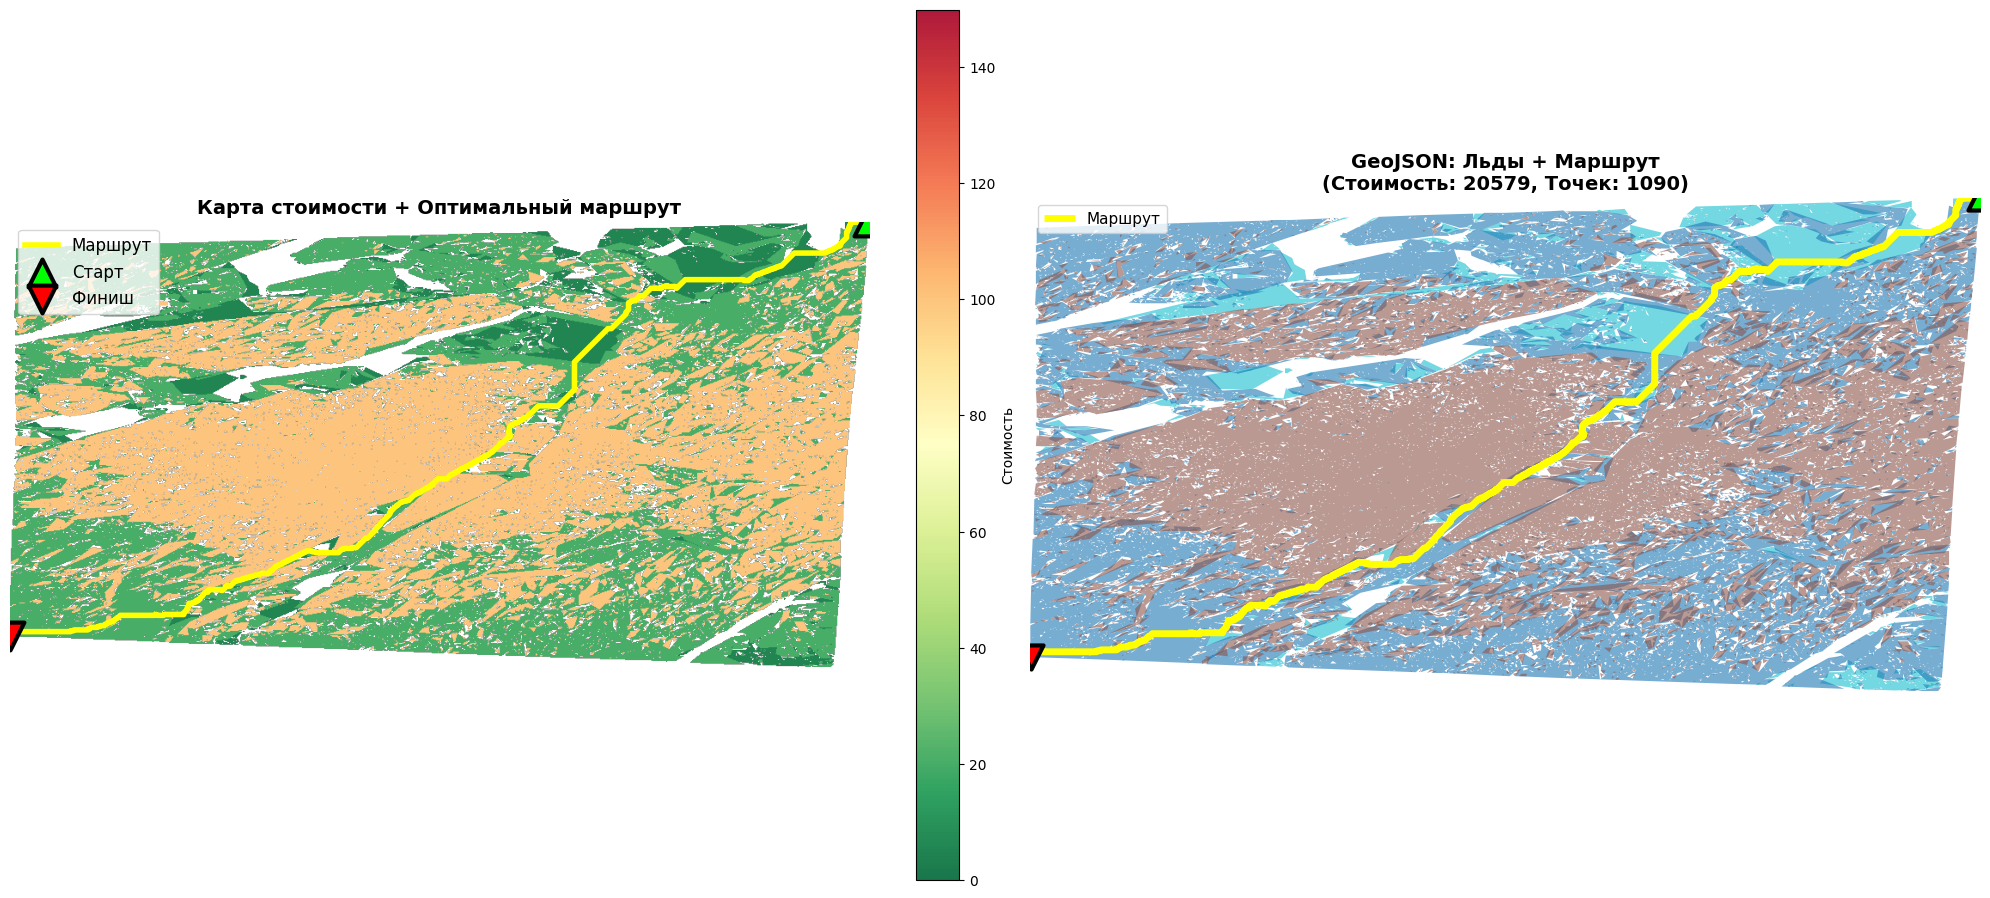


🎉 ГОТОВО!
📥 Скачивается: optimal_route.geojson


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# ПОСТРОЕНИЕ МАРШРУТА - ФИНАЛЬНАЯ ИСПРАВЛЕННАЯ ВЕРСИЯ
# ============================================

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from skimage.graph import route_through_array
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

print("="*60)
print("🚢 ПОСТРОЕНИЕ ОПТИМАЛЬНОГО МАРШРУТА")
print("="*60)

# --- НАСТРОЙКИ ---
GEOJSON_INPUT = 'arctic_route_balanced.geojson'
OUTPUT_ROUTE_GEOJSON = 'optimal_route.geojson'  # Только маршрут

# Стоимости для разных типов льда
COSTS = {
    "Water": 1,
    "Thin Ice": 5,
    "Medium Ice": 20,
    "Thick Ice": 100,
    "Land": 999999
}

# --- ШАГ 1: ЗАГРУЗКА GEOJSON ---
print(f"📥 Загружаем GeoJSON: {GEOJSON_INPUT}")
gdf = gpd.read_file(GEOJSON_INPUT)
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].copy()
if 'ice_type' in gdf.columns:
    gdf['ice_type'] = gdf['ice_type'].str.strip().str.title()
print(f"✅ Загружено {len(gdf)} полигонов")

# --- ШАГ 2: СОЗДАНИЕ РАСТРА ---
print("🗺️ Создаем растровую карту стоимости...")

bounds = gdf.total_bounds
print(f"📐 Границы: {bounds}")

# Разрешение растра
RESOLUTION = 1000
width = RESOLUTION
aspect_ratio = (bounds[3] - bounds[1]) / (bounds[2] - bounds[0])
height = int(width * aspect_ratio)

print(f"📊 Размер растра: {height} x {width}")

from rasterio.transform import from_bounds
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Базовый слой - вся область непроходима (Land)
cost_raster = np.full((height, width), COSTS["Land"], dtype=np.float32)

# Растеризуем только валидные полигоны
print("🧊 Наносим полигоны на растр...")
for ice_type in gdf['ice_type'].unique():
    if ice_type not in COSTS:
        print(f"⚠️ Неизвестный тип: {ice_type}")
        continue

    subset = gdf[gdf['ice_type'] == ice_type]
    shapes = [(geom, COSTS[ice_type]) for geom in subset.geometry if geom.is_valid]

    if shapes:
        features.rasterize(
            shapes=shapes,
            out=cost_raster,
            transform=transform,
            dtype=np.float32
        )
        print(f"  ✓ {ice_type}: {len(shapes)} полигонов")

# --- ШАГ 3: УМНЫЙ ПОИСК ТОЧЕК СТАРТА/ФИНИША ---
print("📍 Ищем точки старта и финиша ВНУТРИ снимка...")

# Ищем все проходимые точки (не Land)
passable_mask = cost_raster < COSTS["Land"]
passable_coords = np.argwhere(passable_mask)

if len(passable_coords) < 2:
    print("❌ Нет проходимых точек!")
    raise ValueError("Карта полностью непроходима")

print(f"✅ Найдено {len(passable_coords)} проходимых точек")

# Вычисляем расстояния от центра
center_r, center_c = height // 2, width // 2
distances = [(r, c, np.sqrt((r-center_r)**2 + (c-center_c)**2))
             for r, c in passable_coords]
distances_sorted = sorted(distances, key=lambda x: x[2], reverse=True)

# Берем самую дальнюю точку как старт
start_candidate = (distances_sorted[0][0], distances_sorted[0][1])

# Ищем финиш - самую дальнюю точку от старта
end_candidates = []
for r, c in passable_coords:
    dist = np.sqrt((r - start_candidate[0])**2 + (c - start_candidate[1])**2)
    end_candidates.append((r, c, dist))

end_candidates_sorted = sorted(end_candidates, key=lambda x: x[2], reverse=True)
end_candidate = (end_candidates_sorted[0][0], end_candidates_sorted[0][1])

# Используем эти точки
start_px = start_candidate
end_px = end_candidate

print(f"🟢 Старт: {start_px} (стоимость: {cost_raster[start_px]:.2f})")
print(f"🔴 Финиш: {end_px} (стоимость: {cost_raster[end_px]:.2f})")

# --- ШАГ 4: ПОСТРОЕНИЕ МАРШРУТА ---
print("🧭 Строим маршрут алгоритмом Дейкстры...")

try:
    indices, weight = route_through_array(
        cost_raster,
        start=start_px,
        end=end_px,
        geometric=True,
        fully_connected=True
    )
    print(f"✅ Маршрут построен!")
    print(f"   💰 Стоимость: {weight:.2f}")
    print(f"   📏 Точек: {len(indices)}")

except Exception as e:
    print(f"❌ Ошибка: {e}")
    raise

# --- ШАГ 5: КОНВЕРТАЦИЯ В КООРДИНАТЫ ---
print("🌍 Конвертируем в географические координаты...")

def pixel_to_coords(row, col, transform):
    x, y = rasterio.transform.xy(transform, row, col)
    return (x, y)

path_coords = [pixel_to_coords(row, col, transform) for row, col in indices]
route_line = LineString(path_coords)

# --- ШАГ 6: СОХРАНЕНИЕ ТОЛЬКО МАРШРУТА ---
print("📝 Создаем GeoJSON только с маршрутом...")

gdf_route = gpd.GeoDataFrame(
    {
        'type': ['route'],
        'name': ['Optimal Arctic Route'],
        'total_cost': [weight],
        'points_count': [len(indices)],
        'length_km': [route_line.length / 1000],  # Примерная длина (очень условно для градусов)
        'start_lat': [path_coords[0][1]],
        'start_lon': [path_coords[0][0]],
        'end_lat': [path_coords[-1][1]],
        'end_lon': [path_coords[-1][0]]
    },
    geometry=[route_line],
    crs=gdf.crs
)

# Сохраняем ТОЛЬКО маршрут
gdf_route.to_file(OUTPUT_ROUTE_GEOJSON, driver='GeoJSON')
print(f"✅ Маршрут сохранен: {OUTPUT_ROUTE_GEOJSON}")

# --- ШАГ 7: ВИЗУАЛИЗАЦИЯ (ИСПРАВЛЕННАЯ) ---
print("📊 Визуализация...")

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# === График 1: Растр ===
ax1 = axes[0]
display_raster = np.where(cost_raster < COSTS["Land"], cost_raster, np.nan)
im = ax1.imshow(display_raster, cmap='RdYlGn_r', vmin=0, vmax=150, alpha=0.9)

route_pixels = [(row, col) for row, col in indices]
ax1.plot([c for r, c in route_pixels],
         [r for r, c in route_pixels],
         color='yellow', linewidth=4, label='Маршрут', alpha=1, zorder=3)

ax1.scatter(start_px[1], start_px[0], c='lime', s=400,
           edgecolors='black', linewidths=3, label='Старт', zorder=5, marker='^')
ax1.scatter(end_px[1], end_px[0], c='red', s=400,
           edgecolors='black', linewidths=3, label='Финиш', zorder=5, marker='v')

plt.colorbar(im, ax=ax1, label='Стоимость', fraction=0.046)
ax1.legend(fontsize=12, loc='upper left')
ax1.set_title('Карта стоимости + Оптимальный маршрут', fontsize=14, fontweight='bold')
ax1.axis('off')

# === График 2: Векторная карта (ИСПРАВЛЕНО) ===
ax2 = axes[1]

# Сначала рисуем данные
gdf.plot(ax=ax2, column='ice_type', legend=True, alpha=0.6,
         edgecolor='none', categorical=True, cmap='tab10')

gdf_route.plot(ax=ax2, color='yellow', linewidth=5, label='Маршрут', zorder=3)

# Точки старта и финиша
start_geo = Point(path_coords[0])
end_geo = Point(path_coords[-1])
gpd.GeoSeries([start_geo], crs=gdf.crs).plot(ax=ax2, color='lime', markersize=300,
                                               edgecolor='black', linewidth=3,
                                               marker='^', zorder=5)
gpd.GeoSeries([end_geo], crs=gdf.crs).plot(ax=ax2, color='red', markersize=300,
                                             edgecolor='black', linewidth=3,
                                             marker='v', zorder=5)

# !!! ИСПРАВЛЕНИЕ ПРОПОРЦИЙ !!!
# 1. Принудительно ставим границы графика точно такими же, как у растра
ax2.set_xlim(bounds[0], bounds[2])
ax2.set_ylim(bounds[1], bounds[3])
# 2. Заставляем оси быть равными (чтобы 1 градус ширины = 1 градус высоты на экране)
ax2.set_aspect('equal', adjustable='box')

ax2.legend(fontsize=11, loc='upper left')
ax2.set_title(f'GeoJSON: Льды + Маршрут\n(Стоимость: {int(weight)}, Точек: {len(indices)})',
              fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎉 ГОТОВО!")
print(f"📥 Скачивается: {OUTPUT_ROUTE_GEOJSON}")
print("="*60)

# Скачивание (для Colab)
try:
    from google.colab import files
    files.download(OUTPUT_ROUTE_GEOJSON)
except ImportError:
    pass